# Preparation (just need to run the first two cells)

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import csv
import scipy.interpolate as interp
import scipy.signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import colorsys
import math
import seaborn as sns
import pandas as pd
from scipy import stats
from itertools import combinations
np.random.seed(1)

In [3]:
def access_data(i,j):
    ## Exp No. i
    No = str(i)
    ## Exp trial. 0 is no action, 1-5 are repeating trials, each contains one ramp.
    trial = str(j)
    h5_filename = "output/No_"+No+"_trial_"+trial+"_sam_v3.h5"
    path = No +'/'
    mask_filename = No +'_mask.png'
    mask_name = path+mask_filename
#     print(mask_name)
#     intensity_filename = No +'_intensity.png'
#     intensity_name = path + intensity_filename
    force_filename = 'data_'+ No+'_'+trial+'.csv'
    force_name = path + force_filename
#     print(force_name)

    if (i==22 or i==23 or i==24 or i==25):
        gt_x = 0
        gt_y = 0
    else:
        with open(path+'gt.txt','r') as f:
            _, gt_x, gt_y = f.readline().strip().split(',')
            gt_x = int(gt_x)
            gt_y = int(gt_y)
        
    return h5_filename, mask_name, force_name, gt_x, gt_y

def read_dataset(h5_filename):
    f = h5py.File(h5_filename, 'r')
    dataset = f.get('data')
    frameCount = int(len(dataset)/nr)
    flow = dataset[:,:].reshape(-1).reshape(-1,384,512,2)
    return frameCount, flow

def read_force(force_name,fc):
    pressure = []
    with open(force_name, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if row != []:
                try:
                    pressure.append(float(row[1]))
                except:
                    continue
    # print(pressure)
    press_interp = interp.interp1d(np.arange(len(pressure)),pressure)
    press_stretch = -press_interp(np.linspace(0,len(pressure)-1,fc))
    return press_stretch

def read_mask(mask_name,ExpNo):
    mask = cv.imread(mask_name)
    mask = mask[:,:,0] # single channel image
#     intensity = cv.imread(intensity_name)
#     intensity = cv.cvtColor(intensity, cv.COLOR_BGR2GRAY)
    mask = cv.threshold(mask, 10, 255, cv.THRESH_BINARY_INV)[1]
#     cv.imwrite('binary_image.png', mask)

    intensity_map = np.zeros([1536,2048],dtype=np.uint8)
    if (ExpNo==1 or ExpNo==2 or ExpNo==3):
        intensity_center = (1132, 731) 
    elif (ExpNo == 4 or ExpNo==5 or ExpNo==6):
        intensity_center = (1134, 744)
    elif (ExpNo == 7 or ExpNo==8 or ExpNo==9):
        intensity_center = (1123, 709) 
    elif (ExpNo == 26):
        intensity_center = (1097, 739) #can
    else:
        intensity_center = (1100, 750) #trail 22~25
    radius = 450
    for r in range(1536):
        for c in range(2048):
            if np.sqrt((c-intensity_center[0])**2+(r-intensity_center[1])**2)<radius:
                intensity_map[r,c] = 255
#     cv.imwrite('binary_image2.png', intensity_map)
    mask_compact = mask[::4,::4]
    intensity_map_compact = intensity_map[::4,::4]
    mask_compact[intensity_map_compact==0]=0
    cv.imwrite('binary_image3.png', mask_compact)
    num_area = np.count_nonzero(mask_compact)
    print(num_area)
    return mask_compact, num_area

nr = 384 # H
nc = 512 # W
# frameCount = int(len(dataset)/nr)
# print(frameCount) # N 

def draw_flow(flow,yy,xx):
    h, w = 1536, 2048
    r, c = flow.shape[:2] 
    scale = 100
    mask = np.zeros((h,w,3), np.uint8)
    for iy in range(r):
        for ix in range(c):
            start_point = (xx[ix],yy[iy])
            end_point = (int(xx[ix]+scale*flow[iy][ix][0]),int(yy[iy]+scale*flow[iy][ix][1]))
            # print(start_point,end_point)
            cv.arrowedLine(mask, start_point,end_point, (0, 255, 0),5)
#     image = cv.circle(mask, (gt_x,gt_y), 5, (0, 0, 255), 3)
    cv.imwrite('flow_map.jpg', mask)

def cal_velocity(flow, dir_x, dir_y):
    flow_x = flow[:,:,0]
    flow_y = flow[:,:,1]
    # sign = np.sign(x*dir_x + y*dir_y)
    velocity = flow_x*dir_x + flow_y*dir_y
    return velocity

def cal_all_velocities(i,flow, gt_x, gt_y, mask_comp,fc):
    Lyy = np.arange(0,nr*4,4)
    Lxx = np.arange(0,nc*4,4)
    LX,LY = np.meshgrid(Lxx,Lyy)
    
    if (i==22 or i==23 or i==24 or i==25):
        dir_x = np.ones((384,512))
        dir_y = -np.ones((384,512))
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    elif (i==26 or i == 36):
        dir_x = np.zeros((384,512))
        dir_y = -np.ones((384,512))
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    else:
        dir_x = gt_x - LX
        dir_y = gt_y - LY
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))

    velocities = np.zeros([fc,nr,nc])

    for k in range(fc):
        velocities[k] = cal_velocity(flow[k],dir_x,dir_y)
        velocities[k][mask_comp==0]=0
    return velocities

def find_ending_point(gt_force):
    force_end = np.argmax(gt_force)
    return force_end

def find_starting_point(gt_force):
    force_start = (np.abs(gt_force - 0.2)).argmin()
    return force_start

def find_target_point(gt_force,target):
    force_target = (np.abs(gt_force - target)).argmin()
    return force_target

# Importing velocity maps

### read the k-th trial from a specific ExpNo, plz type in the ExpNo and trial.

In [5]:
i = 2
ExpNo = i
trial = 1
X={}
Y={}
h5_filename, mask_name, force_name, gt_x, gt_y = access_data(i,trial)
fc, flow = read_dataset(h5_filename)
mask_comp, num_area = read_mask(mask_name,i)
print(h5_filename)
print(force_name)
velocities = cal_all_velocities(i,flow,gt_x,gt_y,mask_comp,fc)
mean_velocity = np.sum(velocities, axis=(1,2))/num_area
est_force = np.cumsum(mean_velocity)
gt_force = read_force(force_name,fc)
force_end = find_ending_point(gt_force)
force_end = int(force_end)
X[str(i)+'_no'] = est_force[:force_end]
Y[str(i)+'_no'] = gt_force[:force_end]
print('finish reading No '+str(i))
print(gt_x,gt_y)
print(mask_name)

27760
output/No_2_trial_1_sam_v3.h5
2/data_2_1.csv
finish reading No 2
1035 538
2/2_mask.png


# plot quiver

In [23]:
# the -100 is added empirically. The force has a little bit delay. no need to change.
force_start = find_starting_point(gt_force) - 100

2.534042709825


In [30]:
# anchor is the frame where the force reaches the target (e.g. 0.2N, 1N, 2N...)
# if you wanna find the frame at other forces, just change the second argument of func.
anchor_0N = find_target_point(gt_force,0.2)-100
anchor_1N = find_target_point(gt_force,1)
anchor_2N = find_target_point(gt_force,2)
anchor_3N = find_target_point(gt_force,3)
anchor_4N = find_target_point(gt_force,4)
anchor_5N = find_target_point(gt_force,5)
print(anchor_0N)
print(anchor_1N)
print(anchor_2N)
print(anchor_3N)
print(anchor_4N)
print(anchor_5N)

937
1796
2735
3796
4579
5434


## to use this, change the k to your desired frame, keep the window size to be 1 (since it is already good enough), keep the scale factor consistent in quiver parameters (e.g. here I use scale = 2000 all the time). Also, the quiver is already oriented correctly. The draw_flow function will save a figure to your current path, which shows vectors in green rather than black (but is not important)

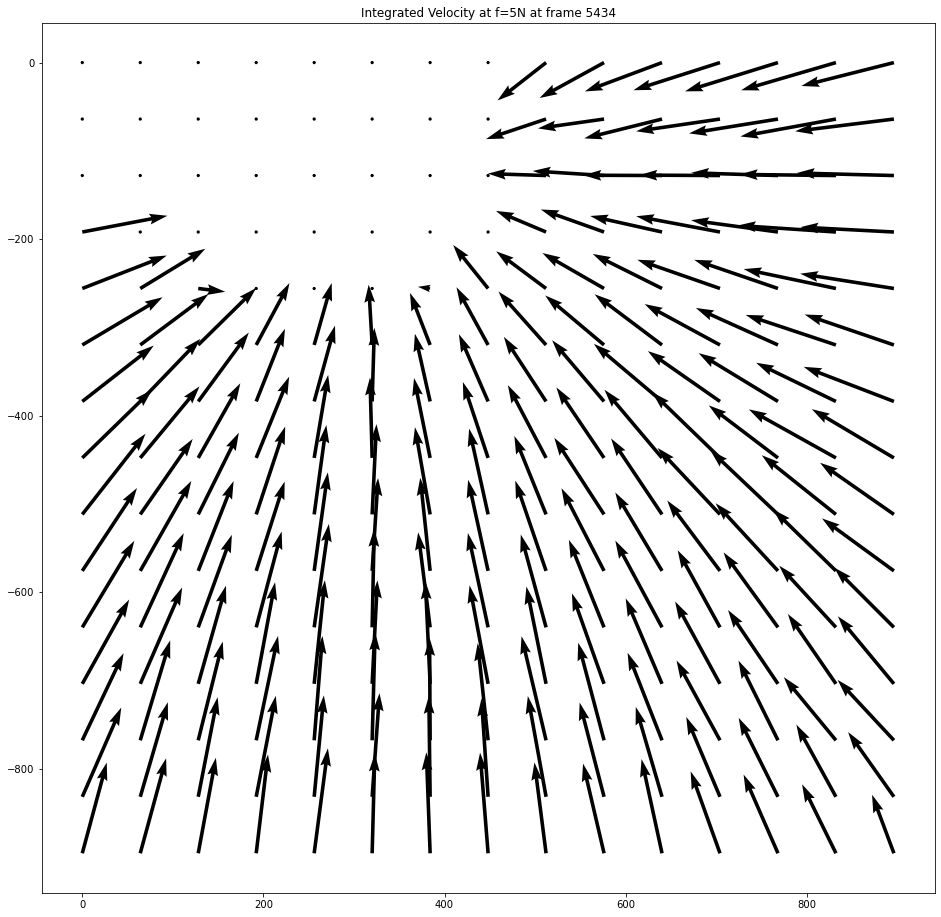

In [66]:
# plot the quiver
yy = np.arange(0,1536,64)
xx = np.arange(0,2048,64)
flow_sparse = flow[:,::16,::16,:]


# the flow_cum is basically the integration!!!

flow_cum = np.cumsum(flow_sparse, axis = 0)
# x_list = flow_cum[:,;,:,0]
# y_list = flow_cum[:,;,:,1]
# print(flow)
k = anchor_5N
win = 1
x_data = np.mean(flow_cum[k:k+win,:,:,0],axis = 0)
#     print(x_data[9:24].shape)
y_data = np.mean(flow_cum[k:k+win,:,:,1],axis = 0)

fig, (ax) = plt.subplots(figsize =(16, 16)) 
ax.quiver(xx[0:15],-yy[0:15], x_data[7:22,12:27], -y_data[7:22,12:27],scale=2000)
ax.set_title('Integrated Velocity at f='+str(5)+'N'+' at frame '+str(k))
plt.savefig('5N.svg')
flow_avg = np.mean(flow_cum[k:k+win,:,:,:],axis = 0)
draw_flow(flow_avg,yy,xx)

# Plz add the center locating part